# Problem Statement: 
> Predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the drive (Quarterly rating, Monthly business acquired, grade, Income)




In [1032]:
import profile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
from warnings import filterwarnings
from statsmodels.stats import weightstats
import statsmodels.api as sm
from scipy import stats
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split , GridSearchCV, RepeatedKFold, cross_val_score, KFold
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve , precision_recall_curve, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE

In [1033]:
data = pd.read_csv('ola_driver.csv')
data

Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  \
0               0  01/01/19          1  28.0     0.0  C23                2   
1               1  02/01/19          1  28.0     0.0  C23                2   
2               2  03/01/19          1  28.0     0.0  C23                2   
3               3  11/01/20          2  31.0     0.0   C7                2   
4               4  12/01/20          2  31.0     0.0   C7                2   
...           ...       ...        ...   ...     ...  ...              ...   
19099       19099  08/01/20       2788  30.0     0.0  C27                2   
19100       19100  09/01/20       2788  30.0     0.0  C27                2   
19101       19101  10/01/20       2788  30.0     0.0  C27                2   
19102       19102  11/01/20       2788  30.0     0.0  C27                2   
19103       19103  12/01/20       2788  30.0     0.0  C27                2   

       Income Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0       57387      24/12/18             NaN                    1      1   
1       57387      24/12/18             NaN                    1      1   
2       57387      24/12/18        03/11/19                    1      1   
3       67016      11/06/20             NaN                    2      2   
4       67016      11/06/20             NaN                    2      2   
...       ...           ...             ...                  ...    ...   
19099   70254      06/08/20             NaN                    2      2   
19100   70254      06/08/20             NaN                    2      2   
19101   70254      06/08/20             NaN                    2      2   
19102   70254      06/08/20             NaN                    2      2   
19103   70254      06/08/20             NaN                    2      2   

       Total Business Value  Quarterly Rating  
0                   2381060                 2  
1                   -665480                 2  
2                         0                 2  
3                         0                 1  
4                         0                 1  
...                     ...               ...  
19099                740280                 3  
19100                448370                 3  
19101                     0                 2  
19102                200420                 2  
19103                411480                 2  

[19104 rows x 14 columns]

In [1034]:
# Removing index column
data = data.drop(['Unnamed: 0'], axis=1)

In [1035]:
profile = ProfileReport(data, title="Spaceship Profiling Report")
profile.to_file(output_file= 'output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [1036]:
profile.to_notebook_iframe()

In [1037]:
data.shape

(19104, 13)

In [1038]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [1039]:
data.describe()

Driver_ID           Age        Gender  Education_Level  \
count  19104.000000  19043.000000  19052.000000     19104.000000   
mean    1415.591133     34.668435      0.418749         1.021671   
std      810.705321      6.257912      0.493367         0.800167   
min        1.000000     21.000000      0.000000         0.000000   
25%      710.000000     30.000000      0.000000         0.000000   
50%     1417.000000     34.000000      0.000000         1.000000   
75%     2137.000000     39.000000      1.000000         2.000000   
max     2788.000000     58.000000      1.000000         2.000000   

              Income  Joining Designation         Grade  Total Business Value  \
count   19104.000000         19104.000000  19104.000000          1.910400e+04   
mean    65652.025126             1.690536      2.252670          5.716621e+05   
std     30914.515344             0.836984      1.026512          1.128312e+06   
min     10747.000000             1.000000      1.000000         -6.000000e+06   
25%     42383.000000             1.000000      1.000000          0.000000e+00   
50%     60087.000000             1.000000      2.000000          2.500000e+05   
75%     83969.000000             2.000000      3.000000          6.997000e+05   
max    188418.000000             5.000000      5.000000          3.374772e+07   

       Quarterly Rating  
count      19104.000000  
mean           2.008899  
std            1.009832  
min            1.000000  
25%            1.000000  
50%            2.000000  
75%            3.000000  
max            4.000000

In [1040]:
data.describe(include='object')

MMM-YY   City Dateofjoining LastWorkingDate
count      19104  19104         19104            1616
unique        24     29           869             493
top     01/01/19    C20      23/07/15        29/07/20
freq        1022   1008           192              70

In [1041]:
# Dropping the duplicate columns
data.drop_duplicates()

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income  \
0      01/01/19          1  28.0     0.0  C23                2   57387   
1      02/01/19          1  28.0     0.0  C23                2   57387   
2      03/01/19          1  28.0     0.0  C23                2   57387   
3      11/01/20          2  31.0     0.0   C7                2   67016   
4      12/01/20          2  31.0     0.0   C7                2   67016   
...         ...        ...   ...     ...  ...              ...     ...   
19099  08/01/20       2788  30.0     0.0  C27                2   70254   
19100  09/01/20       2788  30.0     0.0  C27                2   70254   
19101  10/01/20       2788  30.0     0.0  C27                2   70254   
19102  11/01/20       2788  30.0     0.0  C27                2   70254   
19103  12/01/20       2788  30.0     0.0  C27                2   70254   

      Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0          24/12/18             NaN                    1      1   
1          24/12/18             NaN                    1      1   
2          24/12/18        03/11/19                    1      1   
3          11/06/20             NaN                    2      2   
4          11/06/20             NaN                    2      2   
...             ...             ...                  ...    ...   
19099      06/08/20             NaN                    2      2   
19100      06/08/20             NaN                    2      2   
19101      06/08/20             NaN                    2      2   
19102      06/08/20             NaN                    2      2   
19103      06/08/20             NaN                    2      2   

       Total Business Value  Quarterly Rating  
0                   2381060                 2  
1                   -665480                 2  
2                         0                 2  
3                         0                 1  
4                         0                 1  
...                     ...               ...  
19099                740280                 3  
19100                448370                 3  
19101                     0                 2  
19102                200420                 2  
19103                411480                 2  

[19104 rows x 13 columns]

### KNN Imputation on missing values


In [1042]:
data.isnull().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [1043]:
round(data.isnull().sum()/ len(data)*100, 2)

MMM-YY                   0.00
Driver_ID                0.00
Age                      0.32
Gender                   0.27
City                     0.00
Education_Level          0.00
Income                   0.00
Dateofjoining            0.00
LastWorkingDate         91.54
Joining Designation      0.00
Grade                    0.00
Total Business Value     0.00
Quarterly Rating         0.00
dtype: float64

In [1044]:
imputer = KNNImputer(n_neighbors=3)
data[['Age', 'Gender']] = imputer.fit_transform(data[['Age', 'Gender']])
round(data.isnull().sum()/ len(data)*100, 2)

MMM-YY                   0.00
Driver_ID                0.00
Age                      0.00
Gender                   0.00
City                     0.00
Education_Level          0.00
Income                   0.00
Dateofjoining            0.00
LastWorkingDate         91.54
Joining Designation      0.00
Grade                    0.00
Total Business Value     0.00
Quarterly Rating         0.00
dtype: float64

In [1045]:
data['Gender'].value_counts()

0.000000    11088
1.000000     8001
0.333333       15
Name: Gender, dtype: int64

In [1046]:
# combine 0.333 gender as 0.000 gender
data.loc[((data['Gender'] != 1.000000) & (data['Gender'] != 0.000000)), 'Gender']

466      0.333333
859      0.333333
1892     0.333333
2277     0.333333
2996     0.333333
3289     0.333333
4766     0.333333
5939     0.333333
6695     0.333333
7724     0.333333
9772     0.333333
12092    0.333333
14035    0.333333
18572    0.333333
18928    0.333333
Name: Gender, dtype: float64

In [1047]:
data.loc[((data['Gender'] != 1.000000) & (data['Gender'] != 0.000000)), 'Gender'] = 0.000000
data['Gender'].value_counts()

0.0    11103
1.0     8001
Name: Gender, dtype: int64

In [1048]:
df  = pd.DataFrame()

In [1049]:
pd.DataFrame(data.groupby(['Driver_ID'])['Quarterly Rating'].first())

Quarterly Rating
Driver_ID                  
1                         2
2                         1
4                         1
5                         1
6                         1
...                     ...
2784                      3
2785                      1
2786                      2
2787                      2
2788                      1

[2381 rows x 1 columns]

In [1050]:
data.groupby(['Driver_ID'])['Gender'].count()

Driver_ID
1        3
2        2
4        5
5        3
6        5
        ..
2784    24
2785     3
2786     9
2787     6
2788     7
Name: Gender, Length: 2381, dtype: int64

### Aggregate data in order to remove multiple occurrences of same driver data

In [1051]:
agg_column = ['Age', 'Gender', 'City', 'Education_Level','Income','Dateofjoining', 'Joining Designation', 'Grade', 'Quarterly Rating'] 
for col in agg_column:

    df[col] =  pd.DataFrame(data.groupby(['Driver_ID'])[col].first())
df['ReportingDayCount'] =  pd.DataFrame(data.groupby(['Driver_ID'])['Gender'].count())
df['Total Business Value'] =  pd.DataFrame(data.groupby(['Driver_ID'])['Total Business Value'].sum())
df['Avg Business Value'] =  pd.DataFrame(data.groupby(['Driver_ID'])['Total Business Value'].mean())

df

Age  Gender City  Education_Level  Income Dateofjoining  \
Driver_ID                                                             
1          28.0     0.0  C23                2   57387      24/12/18   
2          31.0     0.0   C7                2   67016      11/06/20   
4          43.0     0.0  C13                2   65603      12/07/19   
5          29.0     0.0   C9                0   46368      01/09/19   
6          31.0     1.0  C11                1   78728      31/07/20   
...         ...     ...  ...              ...     ...           ...   
2784       33.0     0.0  C24                0   82815      15/10/15   
2785       34.0     1.0   C9                0   12105      28/08/20   
2786       44.0     0.0  C19                0   35370      31/07/18   
2787       28.0     1.0  C20                2   69498      21/07/18   
2788       29.0     0.0  C27                2   70254      06/08/20   

           Joining Designation  Grade  Quarterly Rating  ReportingDayCount  \
Driver_ID                                                                    
1                            1      1                 2                  3   
2                            2      2                 1                  2   
4                            2      2                 1                  5   
5                            1      1                 1                  3   
6                            3      3                 1                  5   
...                        ...    ...               ...                ...   
2784                         2      3                 3                 24   
2785                         1      1                 1                  3   
2786                         2      2                 2                  9   
2787                         1      1                 2                  6   
2788                         2      2                 1                  7   

           Total Business Value  Avg Business Value  
Driver_ID                                            
1                       1715580       571860.000000  
2                             0            0.000000  
4                        350000        70000.000000  
5                        120360        40120.000000  
6                       1265000       253000.000000  
...                         ...                 ...  
2784                   21748820       906200.833333  
2785                          0            0.000000  
2786                    2815090       312787.777778  
2787                     977830       162971.666667  
2788                    2298240       328320.000000  

[2381 rows x 12 columns]

# Feature Engineering
### Create a column which tells whether the quarterly rating has increased for that driver

In [1052]:
change = data.groupby(['Driver_ID'])['Quarterly Rating'].last() - data.groupby(['Driver_ID'])['Quarterly Rating'].first() 
df['driver_rating_increased'] = change.apply(lambda x: 1 if x>0 else 0)
df

Age  Gender City  Education_Level  Income Dateofjoining  \
Driver_ID                                                             
1          28.0     0.0  C23                2   57387      24/12/18   
2          31.0     0.0   C7                2   67016      11/06/20   
4          43.0     0.0  C13                2   65603      12/07/19   
5          29.0     0.0   C9                0   46368      01/09/19   
6          31.0     1.0  C11                1   78728      31/07/20   
...         ...     ...  ...              ...     ...           ...   
2784       33.0     0.0  C24                0   82815      15/10/15   
2785       34.0     1.0   C9                0   12105      28/08/20   
2786       44.0     0.0  C19                0   35370      31/07/18   
2787       28.0     1.0  C20                2   69498      21/07/18   
2788       29.0     0.0  C27                2   70254      06/08/20   

           Joining Designation  Grade  Quarterly Rating  ReportingDayCount  \
Driver_ID                                                                    
1                            1      1                 2                  3   
2                            2      2                 1                  2   
4                            2      2                 1                  5   
5                            1      1                 1                  3   
6                            3      3                 1                  5   
...                        ...    ...               ...                ...   
2784                         2      3                 3                 24   
2785                         1      1                 1                  3   
2786                         2      2                 2                  9   
2787                         1      1                 2                  6   
2788                         2      2                 1                  7   

           Total Business Value  Avg Business Value  driver_rating_increased  
Driver_ID                                                                     
1                       1715580       571860.000000                        0  
2                             0            0.000000                        0  
4                        350000        70000.000000                        0  
5                        120360        40120.000000                        0  
6                       1265000       253000.000000                        1  
...                         ...                 ...                      ...  
2784                   21748820       906200.833333                        1  
2785                          0            0.000000                        0  
2786                    2815090       312787.777778                        0  
2787                     977830       162971.666667                        0  
2788                    2298240       328320.000000                        1  

[2381 rows x 13 columns]

### Create a column called target which tells whether the driver has left the company

In [1053]:
df['Target'] = data.groupby(['Driver_ID'])['LastWorkingDate'].last().apply(lambda x: 0 if x==None else 1)
df

Age  Gender City  Education_Level  Income Dateofjoining  \
Driver_ID                                                             
1          28.0     0.0  C23                2   57387      24/12/18   
2          31.0     0.0   C7                2   67016      11/06/20   
4          43.0     0.0  C13                2   65603      12/07/19   
5          29.0     0.0   C9                0   46368      01/09/19   
6          31.0     1.0  C11                1   78728      31/07/20   
...         ...     ...  ...              ...     ...           ...   
2784       33.0     0.0  C24                0   82815      15/10/15   
2785       34.0     1.0   C9                0   12105      28/08/20   
2786       44.0     0.0  C19                0   35370      31/07/18   
2787       28.0     1.0  C20                2   69498      21/07/18   
2788       29.0     0.0  C27                2   70254      06/08/20   

           Joining Designation  Grade  Quarterly Rating  ReportingDayCount  \
Driver_ID                                                                    
1                            1      1                 2                  3   
2                            2      2                 1                  2   
4                            2      2                 1                  5   
5                            1      1                 1                  3   
6                            3      3                 1                  5   
...                        ...    ...               ...                ...   
2784                         2      3                 3                 24   
2785                         1      1                 1                  3   
2786                         2      2                 2                  9   
2787                         1      1                 2                  6   
2788                         2      2                 1                  7   

           Total Business Value  Avg Business Value  driver_rating_increased  \
Driver_ID                                                                      
1                       1715580       571860.000000                        0   
2                             0            0.000000                        0   
4                        350000        70000.000000                        0   
5                        120360        40120.000000                        0   
6                       1265000       253000.000000                        1   
...                         ...                 ...                      ...   
2784                   21748820       906200.833333                        1   
2785                          0            0.000000                        0   
2786                    2815090       312787.777778                        0   
2787                     977830       162971.666667                        0   
2788                    2298240       328320.000000                        1   

           Target  
Driver_ID          
1               1  
2               0  
4               1  
5               1  
6               0  
...           ...  
2784            0  
2785            1  
2786            1  
2787            1  
2788            0  

[2381 rows x 14 columns]

### Create a column which tells whether the monthly income has increased for that driver

In [1054]:
income_increase = data.groupby(['Driver_ID'])['Income'].last() - data.groupby(['Driver_ID'])['Income'].first() 
df['income_increased'] = income_increase.apply(lambda x: 1 if x>0 else 0)
df =df.reset_index()
df

Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining  \
0             1  28.0     0.0  C23                2   57387      24/12/18   
1             2  31.0     0.0   C7                2   67016      11/06/20   
2             4  43.0     0.0  C13                2   65603      12/07/19   
3             5  29.0     0.0   C9                0   46368      01/09/19   
4             6  31.0     1.0  C11                1   78728      31/07/20   
...         ...   ...     ...  ...              ...     ...           ...   
2376       2784  33.0     0.0  C24                0   82815      15/10/15   
2377       2785  34.0     1.0   C9                0   12105      28/08/20   
2378       2786  44.0     0.0  C19                0   35370      31/07/18   
2379       2787  28.0     1.0  C20                2   69498      21/07/18   
2380       2788  29.0     0.0  C27                2   70254      06/08/20   

      Joining Designation  Grade  Quarterly Rating  ReportingDayCount  \
0                       1      1                 2                  3   
1                       2      2                 1                  2   
2                       2      2                 1                  5   
3                       1      1                 1                  3   
4                       3      3                 1                  5   
...                   ...    ...               ...                ...   
2376                    2      3                 3                 24   
2377                    1      1                 1                  3   
2378                    2      2                 2                  9   
2379                    1      1                 2                  6   
2380                    2      2                 1                  7   

      Total Business Value  Avg Business Value  driver_rating_increased  \
0                  1715580       571860.000000                        0   
1                        0            0.000000                        0   
2                   350000        70000.000000                        0   
3                   120360        40120.000000                        0   
4                  1265000       253000.000000                        1   
...                    ...                 ...                      ...   
2376              21748820       906200.833333                        1   
2377                     0            0.000000                        0   
2378               2815090       312787.777778                        0   
2379                977830       162971.666667                        0   
2380               2298240       328320.000000                        1   

      Target  income_increased  
0          1                 0  
1          0                 0  
2          1                 0  
3          1                 0  
4          0                 0  
...      ...               ...  
2376       0                 0  
2377       1                 0  
2378       1                 0  
2379       1                 0  
2380       0                 0  

[2381 rows x 16 columns]

# Statistical summary of the derived dataset

In [1055]:
df.describe()

Driver_ID          Age       Gender  Education_Level         Income  \
count  2381.000000  2381.000000  2381.000000       2381.00000    2381.000000   
mean   1397.559009    33.089038     0.410752          1.00756   59209.060899   
std     806.161628     5.839201     0.492074          0.81629   28275.899087   
min       1.000000    21.000000     0.000000          0.00000   10747.000000   
25%     695.000000    29.000000     0.000000          0.00000   39104.000000   
50%    1400.000000    33.000000     0.000000          1.00000   55276.000000   
75%    2100.000000    37.000000     1.000000          2.00000   75765.000000   
max    2788.000000    58.000000     1.000000          2.00000  188418.000000   

       Joining Designation        Grade  Quarterly Rating  ReportingDayCount  \
count          2381.000000  2381.000000       2381.000000         2381.00000   
mean              1.820244     2.078538          1.486350            8.02352   
std               0.841433     0.931321          0.834348            6.78359   
min               1.000000     1.000000          1.000000            1.00000   
25%               1.000000     1.000000          1.000000            3.00000   
50%               2.000000     2.000000          1.000000            5.00000   
75%               2.000000     3.000000          2.000000           10.00000   
max               5.000000     5.000000          4.000000           24.00000   

       Total Business Value  Avg Business Value  driver_rating_increased  \
count          2.381000e+03        2.381000e+03              2381.000000   
mean           4.586742e+06        3.120854e+05                 0.150357   
std            9.127115e+06        4.495705e+05                 0.357496   
min           -1.385530e+06       -1.979329e+05                 0.000000   
25%            0.000000e+00        0.000000e+00                 0.000000   
50%            8.176800e+05        1.506244e+05                 0.000000   
75%            4.173650e+06        4.294988e+05                 0.000000   
max            9.533106e+07        3.972128e+06                 1.000000   

            Target  income_increased  
count  2381.000000       2381.000000  
mean      0.678706          0.018060  
std       0.467071          0.133195  
min       0.000000          0.000000  
25%       0.000000          0.000000  
50%       1.000000          0.000000  
75%       1.000000          0.000000  
max       1.000000          1.000000

In [1056]:
df.describe(include='object')

City Dateofjoining
count   2381          2381
unique    29           869
top      C20      31/07/20
freq     152            31

In [1057]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Driver_ID                2381 non-null   int64  
 1   Age                      2381 non-null   float64
 2   Gender                   2381 non-null   float64
 3   City                     2381 non-null   object 
 4   Education_Level          2381 non-null   int64  
 5   Income                   2381 non-null   int64  
 6   Dateofjoining            2381 non-null   object 
 7   Joining Designation      2381 non-null   int64  
 8   Grade                    2381 non-null   int64  
 9   Quarterly Rating         2381 non-null   int64  
 10  ReportingDayCount        2381 non-null   int64  
 11  Total Business Value     2381 non-null   int64  
 12  Avg Business Value       2381 non-null   float64
 13  driver_rating_increased  2381 non-null   int64  
 14  Target                  

In [1058]:
# Convert date-like features to their respective data type
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])

# Correlation among independent variables and how they interact with each other



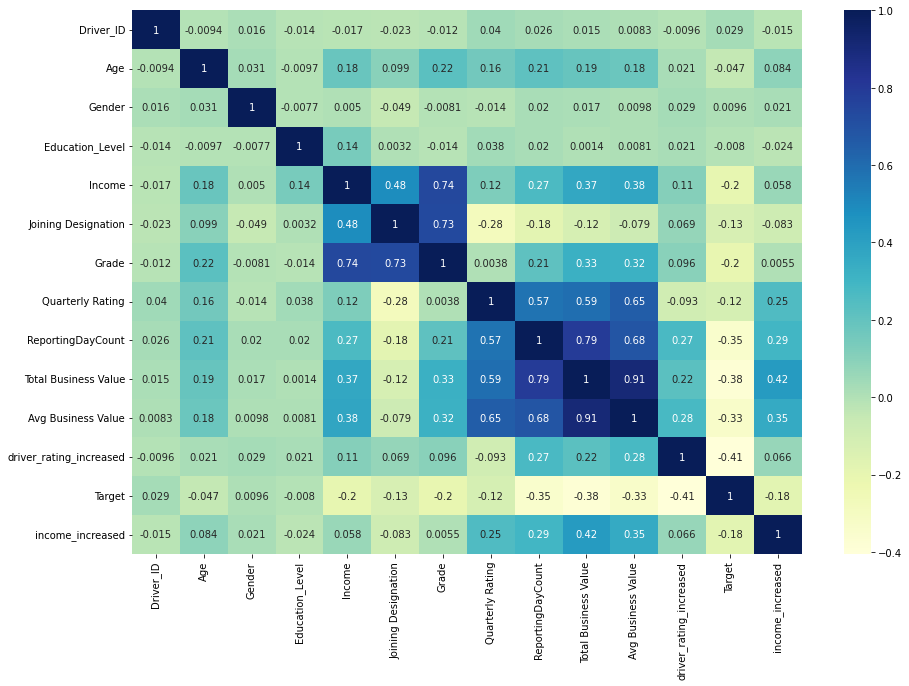

In [1059]:
plt.figure(figsize= (15,10))
sns.heatmap(df.corr(), annot = True, cmap='YlGnBu')
plt.show()

- Very strong +ve correlation between grade and Income, grade and Joining Designation.
- Very strong +ve correlation between Avg Business value and Quarterly Rationg, Total Business Value, Reporting Day count.
- Strong -ve correlation between Target and driver_rating_increased, Avg Business Value, Total Business Value, Reporting Day count.

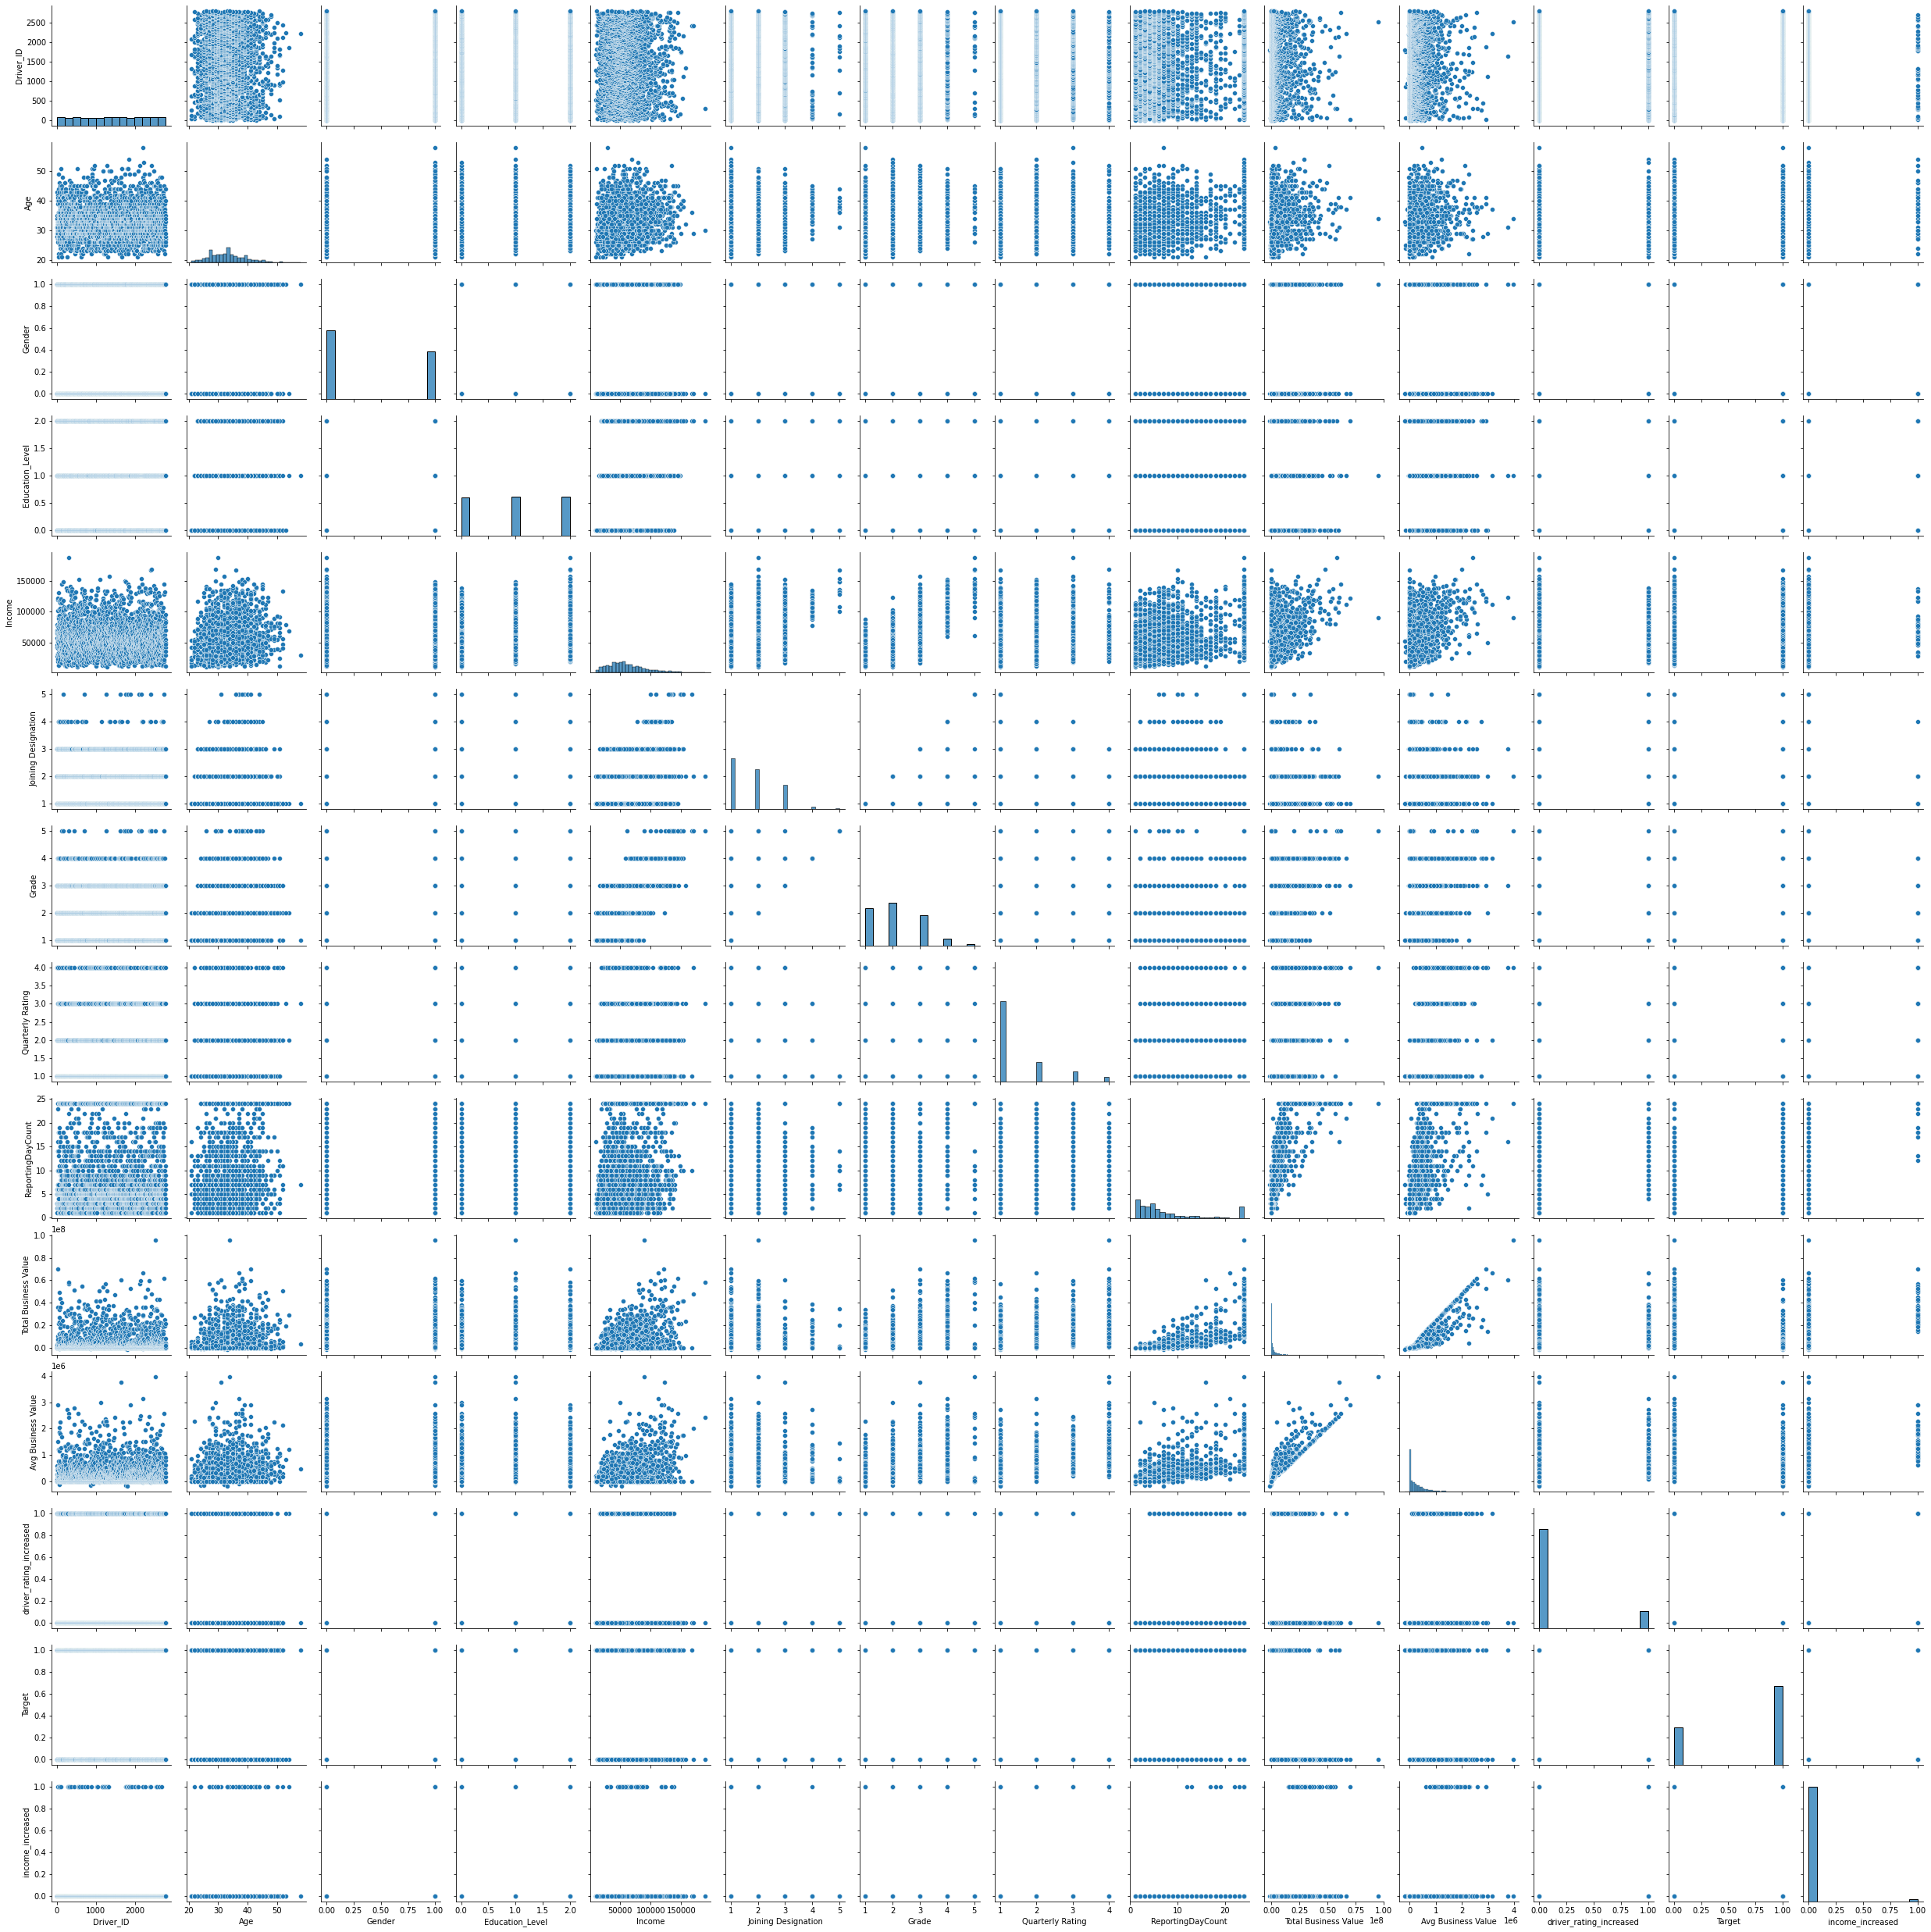

In [1060]:
sns.pairplot(df)
plt.show()

In [1061]:

df[df.columns].nunique()

Driver_ID                  2381
Age                          35
Gender                        2
City                         29
Education_Level               3
Income                     2339
Dateofjoining               869
Joining Designation           5
Grade                         5
Quarterly Rating              4
ReportingDayCount            24
Total Business Value       1629
Avg Business Value         1639
driver_rating_increased       2
Target                        2
income_increased              2
dtype: int64

In [1062]:
category_columns = ['Gender', 'Education_Level','Joining Designation', 'Grade', 'Quarterly Rating', 'driver_rating_increased','income_increased']
numerical_columns = ['Income', 'Total Business Value']
for col in category_columns:
    print(df[col].value_counts())

0.0    1403
1.0     978
Name: Gender, dtype: int64
2    802
1    795
0    784
Name: Education_Level, dtype: int64
1    1026
2     815
3     493
4      36
5      11
Name: Joining Designation, dtype: int64
2    866
1    751
3    611
4    132
5     21
Name: Grade, dtype: int64
1    1649
2     411
3     216
4     105
Name: Quarterly Rating, dtype: int64
0    2023
1     358
Name: driver_rating_increased, dtype: int64
0    2338
1      43
Name: income_increased, dtype: int64



### Univariate Analysis

Lets check the distributions of these features one by one

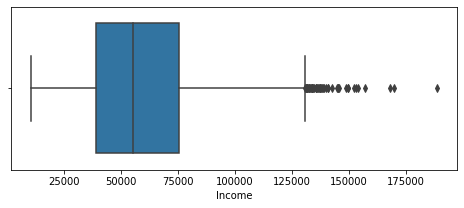

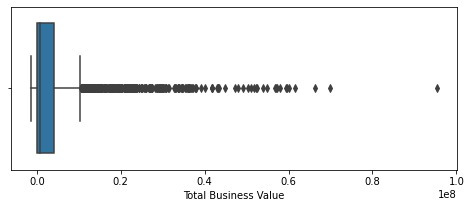

In [1063]:
for j in numerical_columns:
    plt.figure(figsize= (8,3))

    sns.boxplot(df[j])

plt.show()

Outliers are present in Income and Total Business value

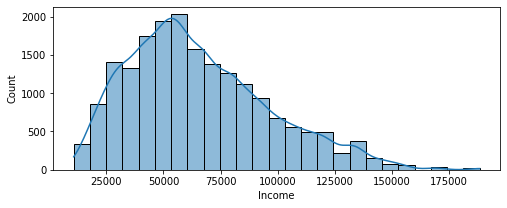

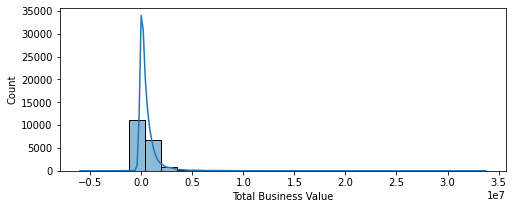

In [1064]:
for j in numerical_columns:
    plt.figure(figsize= (8,3))

    sns.histplot(data[j], kde=True, bins=25)

plt.show()

In [1065]:
df['Income'].value_counts()

48747    3
49664    2
56687    2
57225    2
56243    2
        ..
23823    1
42607    1
36846    1
70330    1
70254    1
Name: Income, Length: 2339, dtype: int64

<AxesSubplot:>

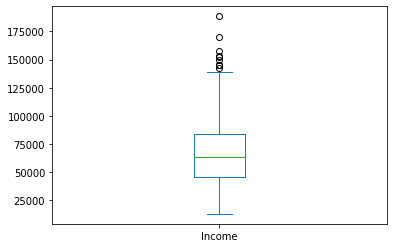

In [1066]:
# df.loc[df['Target']==1, 'Income'].plot(kind = 'box')
df.loc[df['Target']==0, 'Income'].plot(kind = 'box')

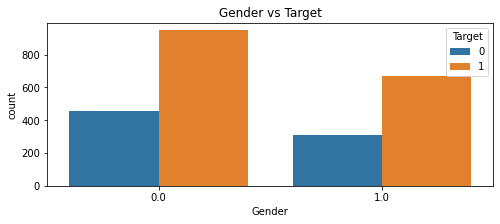

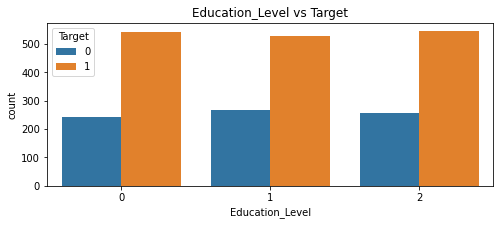

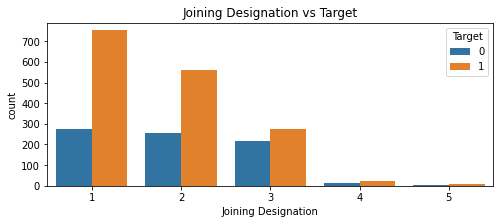

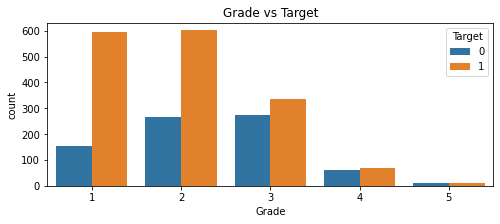

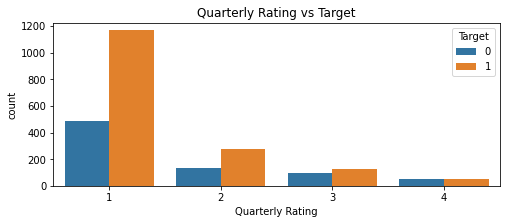

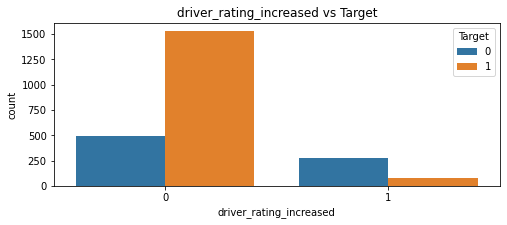

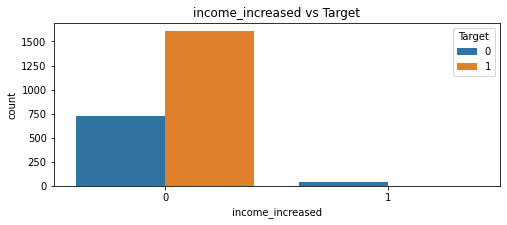

In [1067]:
for col in category_columns:
    plt.figure(figsize=(8,3))
    sns.countplot(df[col], hue=df['Target'])
    plt.title(col +' vs Target')
    plt.show()

- Male Drivers are more churning in number as compared to female driver
- Churning from all the levels of education is almost equal
- Drivers with lower Joining Designation is churning more
- Drivers with lower Grade is churning more
- Drivers whose rating are increased are not very less churning while whose rating has not increased has high churn rate.
- Drivers whose Income are increased are not churning while whose Income has not increased has high churn rate.

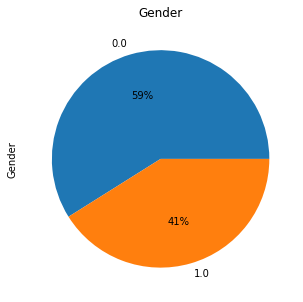

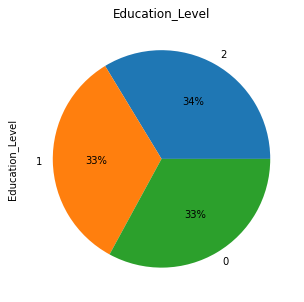

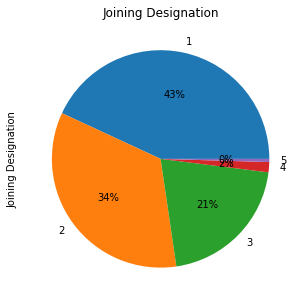

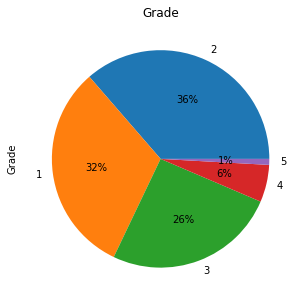

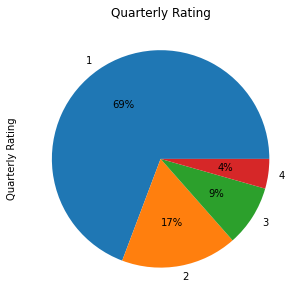

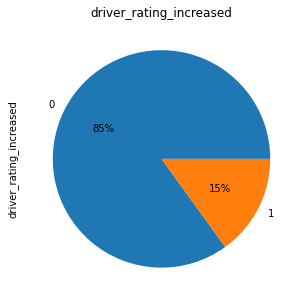

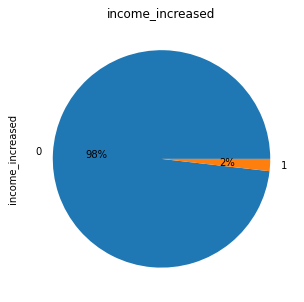

In [1068]:
for col in category_columns:
    plt.figure(figsize=(8,3))
    df[col].value_counts().plot(kind= 'pie', figsize=(8,5), autopct= '%1.0f%%')
    plt.xticks(rotation = 90)
    plt.title(col)
    plt.show()


- Only 15% drivers have been able to increase its rating
- Only 2% drivers have been able to increade its Income.
- 69% drivers have 1 Quarterly Rating.
- Only 4% drivers have 4 Quarterly Rating.
- Drivers come from all types of education level in equal proportion
- 41% of drivers are females
- 43% of drivers joins with designation level 1


# Data preparation for modeling
## One hot and Target encoding of the categorical variable

In [1069]:
df[df.columns].nunique()

Driver_ID                  2381
Age                          35
Gender                        2
City                         29
Education_Level               3
Income                     2339
Dateofjoining               869
Joining Designation           5
Grade                         5
Quarterly Rating              4
ReportingDayCount            24
Total Business Value       1629
Avg Business Value         1639
driver_rating_increased       2
Target                        2
income_increased              2
dtype: int64

In [1070]:
# Converting categorical column into category
df[category_columns] = df[category_columns].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Driver_ID                2381 non-null   int64         
 1   Age                      2381 non-null   float64       
 2   Gender                   2381 non-null   category      
 3   City                     2381 non-null   object        
 4   Education_Level          2381 non-null   category      
 5   Income                   2381 non-null   int64         
 6   Dateofjoining            2381 non-null   datetime64[ns]
 7   Joining Designation      2381 non-null   category      
 8   Grade                    2381 non-null   category      
 9   Quarterly Rating         2381 non-null   category      
 10  ReportingDayCount        2381 non-null   int64         
 11  Total Business Value     2381 non-null   int64         
 12  Avg Business Value       2381 non-

In [1071]:
dummies =  ['Gender', 'Education_Level', 'Quarterly Rating', 'driver_rating_increased', 'income_increased']
df = pd.get_dummies(data = df,columns=dummies,  drop_first=True)

In [1072]:
df

Driver_ID   Age City  Income Dateofjoining Joining Designation Grade  \
0             1  28.0  C23   57387    2018-12-24                   1     1   
1             2  31.0   C7   67016    2020-11-06                   2     2   
2             4  43.0  C13   65603    2019-12-07                   2     2   
3             5  29.0   C9   46368    2019-01-09                   1     1   
4             6  31.0  C11   78728    2020-07-31                   3     3   
...         ...   ...  ...     ...           ...                 ...   ...   
2376       2784  33.0  C24   82815    2015-10-15                   2     3   
2377       2785  34.0   C9   12105    2020-08-28                   1     1   
2378       2786  44.0  C19   35370    2018-07-31                   2     2   
2379       2787  28.0  C20   69498    2018-07-21                   1     1   
2380       2788  29.0  C27   70254    2020-06-08                   2     2   

      ReportingDayCount  Total Business Value  Avg Business Value  Target  \
0                     3               1715580       571860.000000       1   
1                     2                     0            0.000000       0   
2                     5                350000        70000.000000       1   
3                     3                120360        40120.000000       1   
4                     5               1265000       253000.000000       0   
...                 ...                   ...                 ...     ...   
2376                 24              21748820       906200.833333       0   
2377                  3                     0            0.000000       1   
2378                  9               2815090       312787.777778       1   
2379                  6                977830       162971.666667       1   
2380                  7               2298240       328320.000000       0   

      Gender_1.0  Education_Level_1  Education_Level_2  Quarterly Rating_2  \
0              0                  0                  1                   1   
1              0                  0                  1                   0   
2              0                  0                  1                   0   
3              0                  0                  0                   0   
4              1                  1                  0                   0   
...          ...                ...                ...                 ...   
2376           0                  0                  0                   0   
2377           1                  0                  0                   0   
2378           0                  0                  0                   1   
2379           1                  0                  1                   1   
2380           0                  0                  1                   0   

      Quarterly Rating_3  Quarterly Rating_4  driver_rating_increased_1  \
0                      0                   0                          0   
1                      0                   0                          0   
2                      0                   0                          0   
3                      0                   0                          0   
4                      0                   0                          1   
...                  ...                 ...                        ...   
2376                   1                   0                          1   
2377                   0                   0                          0   
2378                   0                   0                          0   
2379                   0                   0                          0   
2380                   0                   0                          1   

      income_increased_1  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
...                  ...  
2376                   0  
2377                   0  
2378                   0  
2379                   0  
2380     

In [1073]:
df[df.columns].nunique()

Driver_ID                    2381
Age                            35
City                           29
Income                       2339
Dateofjoining                 869
Joining Designation             5
Grade                           5
ReportingDayCount              24
Total Business Value         1629
Avg Business Value           1639
Target                          2
Gender_1.0                      2
Education_Level_1               2
Education_Level_2               2
Quarterly Rating_2              2
Quarterly Rating_3              2
Quarterly Rating_4              2
driver_rating_increased_1       2
income_increased_1              2
dtype: int64

In [1074]:
target_encoder_category = ['Age', 'City', 'Joining Designation', 'Grade', 'ReportingDayCount']
for col in target_encoder_category:
    te = TargetEncoder()
    df[col] = te.fit_transform(df[col], df['Target'])

In [1075]:
df.T

0                    1     \
Driver_ID                                    1                    2   
Age                                       28.0                 31.0   
City                                   0.77027             0.684211   
Income                                   57387                67016   
Dateofjoining              2018-12-24 00:00:00  2020-11-06 00:00:00   
Joining Designation                   0.732943             0.687117   
Grade                                 0.793609             0.693995   
ReportingDayCount                            3                    2   
Total Business Value                   1715580                    0   
Avg Business Value                    571860.0                  0.0   
Target                                       1                    0   
Gender_1.0                                   0                    0   
Education_Level_1                            0                    0   
Education_Level_2                            1                    1   
Quarterly Rating_2                           1                    0   
Quarterly Rating_3                           0                    0   
Quarterly Rating_4                           0                    0   
driver_rating_increased_1                    0                    0   
income_increased_1                           0                    0   

                                          2                    3     \
Driver_ID                                    4                    5   
Age                                       43.0                 29.0   
City                                  0.816901             0.706667   
Income                                   65603                46368   
Dateofjoining              2019-12-07 00:00:00  2019-01-09 00:00:00   
Joining Designation                   0.687117             0.732943   
Grade                                 0.693995             0.793609   
ReportingDayCount                            5                    3   
Total Business Value                    350000               120360   
Avg Business Value                     70000.0              40120.0   
Target                                       1                    1   
Gender_1.0                                   0                    0   
Education_Level_1                            0                    0   
Education_Level_2                            1                    0   
Quarterly Rating_2                           0                    0   
Quarterly Rating_3                           0                    0   
Quarterly Rating_4                           0                    0   
driver_rating_increased_1                    0                    0   
income_increased_1                           0                    0   

                                          4                    5     \
Driver_ID                                    6                    8   
Age                                       31.0                 34.0   
City                                  0.703125             0.763889   
Income                                   78728                70656   
Dateofjoining              2020-07-31 00:00:00  2020-09-19 00:00:00   
Joining Designation                   0.555781             0.555781   
Grade                                 0.551555             0.551555   
ReportingDayCount                            5                    3   
Total Business Value                   1265000                    0   
Avg Business Value                    253000.0                  0.0   
Target                                       0                    1   
Gender_1.0                                   1                    0   
Education_Level_1                            1                    0   
Education_Level_2                            0                    0   
Quarterly Rating_2                           0                    0   
Quarterly Rating_3                           0                  

In [1076]:
df.groupby(by='Target')['Total Business Value'].describe()

count          mean           std        min       25%        50%  \
Target                                                                       
0        765.0  9.620626e+06  1.323157e+07        0.0  240920.0  2636210.0   
1       1616.0  2.203746e+06  4.717754e+06 -1385530.0       0.0   465025.0   

               75%         max  
Target                          
0       16290800.0  95331060.0  
1        2345702.5  60153830.0

In [1077]:
df

Driver_ID   Age      City  Income Dateofjoining  Joining Designation  \
0             1  28.0  0.770270   57387    2018-12-24             0.732943   
1             2  31.0  0.684211   67016    2020-11-06             0.687117   
2             4  43.0  0.816901   65603    2019-12-07             0.687117   
3             5  29.0  0.706667   46368    2019-01-09             0.732943   
4             6  31.0  0.703125   78728    2020-07-31             0.555781   
...         ...   ...       ...     ...           ...                  ...   
2376       2784  33.0  0.698630   82815    2015-10-15             0.687117   
2377       2785  34.0  0.706667   12105    2020-08-28             0.732943   
2378       2786  44.0  0.569444   35370    2018-07-31             0.687117   
2379       2787  28.0  0.730263   69498    2018-07-21             0.732943   
2380       2788  29.0  0.674157   70254    2020-06-08             0.687117   

         Grade  ReportingDayCount  Total Business Value  Avg Business Value  \
0     0.793609                  3               1715580       571860.000000   
1     0.693995                  2                     0            0.000000   
2     0.693995                  5                350000        70000.000000   
3     0.793609                  3                120360        40120.000000   
4     0.551555                  5               1265000       253000.000000   
...        ...                ...                   ...                 ...   
2376  0.551555                 24              21748820       906200.833333   
2377  0.793609                  3                     0            0.000000   
2378  0.693995                  9               2815090       312787.777778   
2379  0.793609                  6                977830       162971.666667   
2380  0.693995                  7               2298240       328320.000000   

      Target  Gender_1.0  Education_Level_1  Education_Level_2  \
0          1           0                  0                  1   
1          0           0                  0                  1   
2          1           0                  0                  1   
3          1           0                  0                  0   
4          0           1                  1                  0   
...      ...         ...                ...                ...   
2376       0           0                  0                  0   
2377       1           1                  0                  0   
2378       1           0                  0                  0   
2379       1           1                  0                  1   
2380       0           0                  0                  1   

      Quarterly Rating_2  Quarterly Rating_3  Quarterly Rating_4  \
0                      1                   0                   0   
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
2376                   0                   1                   0   
2377                   0                   0                   0   
2378                   1                   0                   0   
2379                   1                   0                   0   
2380                   0                   0                   0   

      driver_rating_increased_1  income_increased_1  
0                             0                   0  
1                             0                   0  
2                             0                   0  
3                             0                   0  
4                             1                   0  
...                         ...                 ...  
2376                          1                   0  
2377                          0                   0  
2378                    

In [1078]:
# Removing Driver_ID column
df.drop(['Driver_ID', 'Dateofjoining'], inplace= True, axis=1)

## Outlier treatment

In [1079]:
df2 = df.copy()
for i,j in enumerate(numerical_columns):
    q1=df2[j].quantile(0.25)
    q3=df2[j].quantile(0.75)
    iqr=q3-q1

    df2=df2[(df2[j]>=q1-1.5*iqr)&(df2[j]<=q3+1.5*iqr)]

In [1080]:
df2.shape

(2017, 17)

In [1081]:
df.shape[0]

2381

In [1082]:
# % of data removed as outlier
((df.shape[0]- df2.shape[0]) / df.shape[0])*100

15.287694246115077


Since we have less data and 15% of data will be removed as outlier so we are not removing outlier.

## Spliting dataset in train , test

In [1083]:
X = df.drop('Target', axis=1)
y = df['Target']

In [1084]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    stratify=y, random_state=42)

In [1085]:
print(X_train.shape)
print(X_test.shape)

(1666, 16)
(715, 16)


## Class Imbalance Treatment

In [1086]:
sm = SMOTE()
X_train_sm, y_train_sm =  sm.fit_resample(X_train, y_train )

In [1087]:
Counter(y_train_sm)

Counter({1: 1131, 0: 1131})

## Standardization 

In [1088]:
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)

In [1089]:
X_train_sm

array([[-1.89144916, -1.01827342,  0.3251438 , ..., -0.17605005,
         2.24321198, -0.12536431],
       [-1.5230005 ,  0.89135778,  0.01591098, ..., -0.17605005,
        -0.44578934, -0.12536431],
       [ 0.50346712, -0.57378768,  0.44215575, ..., -0.17605005,
         2.24321198, -0.12536431],
       ...,
       [-0.87592224,  0.66393745, -0.13468941, ..., -0.17605005,
        -0.44578934, -0.12536431],
       [ 0.43208267, -0.16225921, -0.29021855, ..., -0.17605005,
        -0.44578934, -0.12536431],
       [ 1.54278027, -1.61035561,  0.20229039, ..., -0.17605005,
        -0.44578934, -0.12536431]])

# Ensemble learning - Bagging, Boosting methods with some hyper-parameter tuning

In [1090]:
rf = RandomForestClassifier(n_estimators = 100, random_state=2, max_depth = 4)
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=4, random_state=2)

In [1091]:
rf.n_features_

16

In [1092]:
print(f'Train Accuracy:{rf.score(X_train_sm,y_train_sm)}')

Train Accuracy:0.7948717948717948


In [1093]:
y_pred = rf.predict(X_test)
print('Accuracy of Random Forest classifier on test set is: {:.3f}'.format (rf.score(X_test, y_test)))


Accuracy of Random Forest classifier on test set is: 0.772


## Results Evaluation
### Confusion Matrix

In [1094]:
cm= confusion_matrix(y_test, y_pred)
cm

array([[161,  69],
       [ 94, 391]], dtype=int64)

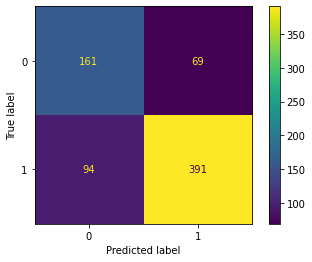

In [1095]:
ConfusionMatrixDisplay(cm).plot()

### Classification Report

In [1096]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       230
           1       0.85      0.81      0.83       485

    accuracy                           0.77       715
   macro avg       0.74      0.75      0.75       715
weighted avg       0.78      0.77      0.77       715



### ROC Curve
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classiﬁcation
model at all classiﬁcation thresholds. This curve plots two parameters:
True Positive Rate
False Positive Rate
True Positive Rate (TPR) is a synonym for recall and is therefore deﬁned as follows:
TPR=(TP)/(TP+FN)
False Positive Rate (FPR) is deﬁned as follows:
FPR=(FP)/(FP+TN)
An ROC curve plots TPR vs. FPR at diﬀerent classiﬁcation thresholds. Lowering the classiﬁcation threshold
classiﬁes more items as positive, thus increasing both False Positives and True Positives. The following ﬁgure
shows a typical ROC curve.

### AUC (Area under the ROC Curve) -
AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area
underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).
AUC provides an aggregate measure of performance across all possible classiﬁcation thresholds. One way of
interpreting AUC is as the probability that the model ranks a random positive example more highly than a
random negative example. For example, given the following examples, which are arranged from left to right in
ascending order of logistic regression predictions:

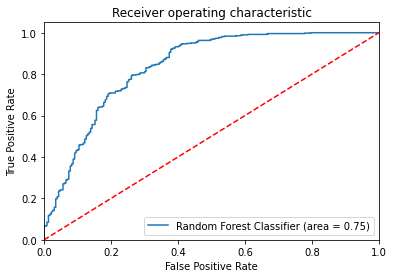

In [1097]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

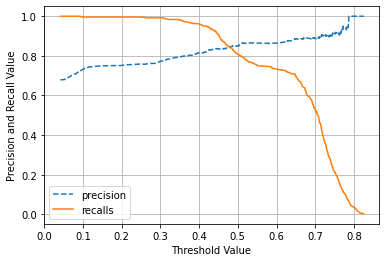

In [1098]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, rf.predict_proba(X_test)[:,1])


### Multicollinearity check using Variance Inﬂation Factor (VIF) -
Multicollinearity occurs when two or more independent variables are highly correlated with one another in a
regression model. Multicollinearity can be a problem in a regression model because we would not be able to
distinguish between the individual eﬀects of the independent variables on the dependent variable.

In [1099]:
X 

Age      City  Income  Joining Designation     Grade  \
0     28.0  0.770270   57387             0.732943  0.793609   
1     31.0  0.684211   67016             0.687117  0.693995   
2     43.0  0.816901   65603             0.687117  0.693995   
3     29.0  0.706667   46368             0.732943  0.793609   
4     31.0  0.703125   78728             0.555781  0.551555   
...    ...       ...     ...                  ...       ...   
2376  33.0  0.698630   82815             0.687117  0.551555   
2377  34.0  0.706667   12105             0.732943  0.793609   
2378  44.0  0.569444   35370             0.687117  0.693995   
2379  28.0  0.730263   69498             0.732943  0.793609   
2380  29.0  0.674157   70254             0.687117  0.693995   

      ReportingDayCount  Total Business Value  Avg Business Value  Gender_1.0  \
0                     3               1715580       571860.000000           0   
1                     2                     0            0.000000           0   
2                     5                350000        70000.000000           0   
3                     3                120360        40120.000000           0   
4                     5               1265000       253000.000000           1   
...                 ...                   ...                 ...         ...   
2376                 24              21748820       906200.833333           0   
2377                  3                     0            0.000000           1   
2378                  9               2815090       312787.777778           0   
2379                  6                977830       162971.666667           1   
2380                  7               2298240       328320.000000           0   

      Education_Level_1  Education_Level_2  Quarterly Rating_2  \
0                     0                  1                   1   
1                     0                  1                   0   
2                     0                  1                   0   
3                     0                  0                   0   
4                     1                  0                   0   
...                 ...                ...                 ...   
2376                  0                  0                   0   
2377                  0                  0                   0   
2378                  0                  0                   1   
2379                  0                  1                   1   
2380                  0                  1                   0   

      Quarterly Rating_3  Quarterly Rating_4  driver_rating_increased_1  \
0                      0                   0                          0   
1                      0                   0                          0   
2                      0                   0                          0   
3                      0                   0                          0   
4                      0                   0                          1   
...                  ...                 ...                        ...   
2376                   1                   0                          1   
2377                   0                   0                          0   
2378                   0                   0                          0   
2379                   0                   0                          0   
2380                   0                   0                          1   

      income_increased_1  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
...                  ...  
2376                   0  
2377                   0  
2378                   0  
2379                   0  
2380                   0  

[2381 rows x 16 columns]

In [1100]:
variance_inflation_factor(X.values, 1)

77.16695805606614

In [1101]:
def calc_vif(X):
    # Calculating the VIF
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

calc_vif(X)[:5]

Feature     VIF
3   Joining Designation  336.42
4                 Grade  239.12
1                  City   77.17
0                   Age   31.51
6  Total Business Value   13.46

In [1102]:
# Removing Joining Designation
X.drop(['Joining Designation'], axis = 1, inplace=True)
calc_vif(X)[:5]

Feature    VIF
1                  City  71.47
3                 Grade  49.93
0                   Age  30.63
5  Total Business Value  13.31
6    Avg Business Value  13.24

In [1103]:
# Removing City
X.drop(['City'], axis = 1, inplace=True)
calc_vif(X)[:5]

Feature    VIF
0                   Age  27.27
2                 Grade  19.84
4  Total Business Value  13.27
5    Avg Business Value  13.19
3     ReportingDayCount   8.95

In [1104]:
# Removing Age
X.drop(['Age'], axis = 1, inplace=True)
calc_vif(X)[:5]

Feature    VIF
3  Total Business Value  13.23
4    Avg Business Value  13.15
2     ReportingDayCount   8.80
1                 Grade   6.52
0                Income   5.23

In [1105]:
# Removing Total Business Value
X.drop(['Total Business Value'], axis = 1, inplace=True)
calc_vif(X)[:5]

Feature   VIF
1               Grade  5.71
2   ReportingDayCount  5.30
0              Income  5.21
3  Avg Business Value  4.66
6   Education_Level_2  2.12

In [1106]:
X.shape

(2381, 12)

In [1107]:
y.value_counts()

1    1616
0     765
Name: Target, dtype: int64

In [1108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    stratify=y, random_state=42)

In [1109]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [1110]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (2262, 12)
After OverSampling, the shape of train_y: (2262,) 

After OverSampling, counts of label '1': 1131
After OverSampling, counts of label '0': 1131


### Hyper-Parameter Tuning using GridSearchCV

In [1111]:
rfc=RandomForestClassifier(random_state=42)
params = [{'n_estimators':[100,200,300,400], 'max_depth':[4,5,6,7,8], 'max_features':['auto', 'log'], 'criterion':['gini', 'entropy']}]

In [1112]:
cv_rfc= GridSearchCV(estimator = rfc, param_grid= params, cv = 5)
cv_rfc.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 5, 6, 7, 8],
                          'max_features': ['auto', 'log'],
                          'n_estimators': [100, 200, 300, 400]}])

In [1113]:
cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 400}

In [1114]:
cv_rfc1 = RandomForestClassifier(n_estimators=400, max_depth=8, max_features='auto', criterion ='gini')
cv_rfc1.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=8, max_features='auto', n_estimators=400)

In [1115]:
# X = scaler.fit_transform(X)

kfold = KFold(n_splits=5)
accuracy = np.mean(cross_val_score(cv_rfc1, X, y, cv=kfold, scoring='accuracy', n_jobs=-1))
print("Cross Validation accuracy: {:.3f}".format(accuracy))

Cross Validation accuracy: 0.825


# XGBoostClassifier

In [1116]:
xgbc = XGBClassifier(objective="binary:logistic", random_state=42)
xgbc.fit(X_train_res, y_train_res)
print(f'Train Accuracy:{xgbc.score(X_train_res,y_train_res)}')
  


Train Accuracy:0.9681697612732095


In [1117]:
y_pred = xgbc.predict(X_test)
print('Accuracy of XGBoost classifier on test set is: {:.3f}'.format (xgbc.score(X_test, y_test)))

Accuracy of XGBoost classifier on test set is: 0.806


## Results Evaluation
### Confusion Matrix

In [1118]:
cm= confusion_matrix(y_test, y_pred)
cm

array([[153,  77],
       [ 62, 423]], dtype=int64)

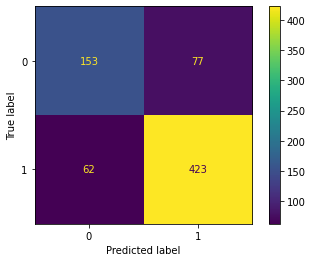

In [1119]:
ConfusionMatrixDisplay(cm).plot()

### Classification Report

In [1120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       230
           1       0.85      0.87      0.86       485

    accuracy                           0.81       715
   macro avg       0.78      0.77      0.77       715
weighted avg       0.80      0.81      0.80       715



### ROC-AUC Curve

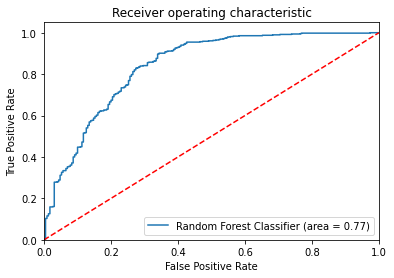

In [1121]:
xgbc_roc_auc = roc_auc_score(y_test, xgbc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgbc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % xgbc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

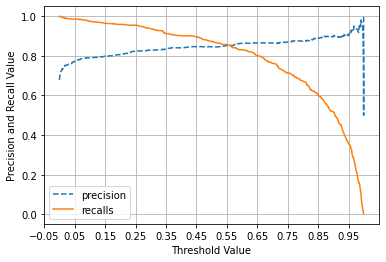

In [1122]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, xgbc.predict_proba(X_test)[:,1])


In [1123]:
X = scaler.fit_transform(X)

kfold = KFold(n_splits=5)
accuracy = np.mean(cross_val_score(xgbc, X, y, cv=kfold, scoring='accuracy', n_jobs=-1))
print("Cross Validation accuracy: {:.3f}".format(accuracy))

Cross Validation accuracy: 0.808


### Hyper-Parameter Tuning using GridSearchCV

In [1124]:
xgbc=XGBClassifier(objective='binary:logistic', random_state=42)
params ={
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    
}

In [1125]:
# cv_xgbc= GridSearchCV(estimator = xgbc, param_grid= params, cv = 5)
# cv_xgbc.fit(X_train_res, y_train_res)

# Insights & Recommendations

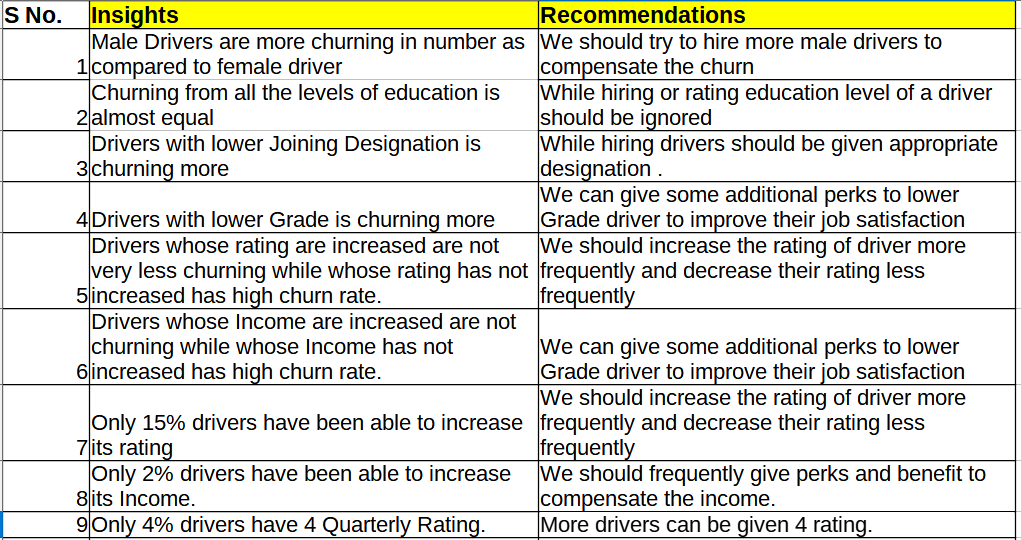